## Library import + training function 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse.linalg import eigsh
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import math

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)

def compute_posterior_mean_multidim_batch(y_t, t, mu1, mu2, w):
    """
    Compute E[X | y_t] for a batch of y_t vectors in R^n.
    
    Parameters:
    - y_t: np.array shape (batch_size, n)
    - mu1, mu2: np.array shape (n,)
    - w: scalar in (0,1)
    - t: scalar

    Returns:
    - posterior_mean: np.array shape (batch_size, n)
    """
    cov = t * (t + 1)

    # Ensure mu1 and mu2 are broadcastable
    mu1 = mu1.reshape(1, -1)  # shape: (1, n)
    mu2 = mu2.reshape(1, -1)

    delta1 = y_t - t * mu1  # shape: (batch_size, n)
    delta2 = y_t - t * mu2

    logp1 = -0.5 * np.sum(delta1**2, axis=1) / cov  # shape: (batch_size,)
    logp2 = -0.5 * np.sum(delta2**2, axis=1) / cov

    max_logp = np.maximum(logp1, logp2)
    p1 = w * np.exp(logp1 - max_logp)
    p2 = (1 - w) * np.exp(logp2 - max_logp)
    Z = p1 + p2

    gamma1 = (p1 / Z).reshape(-1, 1)  # shape: (batch_size, 1)
    gamma2 = (p2 / Z).reshape(-1, 1)

    # Posterior mean
    posterior_mean = (1 / (t + 1)) * y_t + (1 / (t + 1)) * (gamma1 * mu1 + gamma2 * mu2)
    return posterior_mean

def training(denoiser, 
             samples, 
             num_epochs=200, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(denoiser.parameters(), lr=lr, weight_decay=weight_decay)

    batch_size = 50
    device = torch.device("cpu")

    best_val_loss = float('inf')
    best_model_state = None
    true_loss = 0

    samples_train, samples_val = train_test_split(samples, test_size=0.4, random_state=42)
    train_tensor = torch.tensor(samples_train, dtype=torch.float32)
    val_tensor = torch.tensor(samples_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=5, shuffle=False)

    for epoch in range(num_epochs):
        denoiser.train()
        running_loss = 0.0

        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()

            alpha_vals = np.random.uniform(0, alpha_max, size=(batch_X.shape[0],))
            alpha = torch.tensor(alpha_vals, dtype=torch.float32, device=device).unsqueeze(1)
            t = torch.tan(alpha).pow(2)

            noise = torch.randn_like(batch_X)
            input = (t * batch_X + t.sqrt() * noise)
            target = batch_X

            output = denoiser(input, alpha.squeeze(1))
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(denoiser.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # === VALIDATION ===
        denoiser.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_X, _ in val_loader:
                batch_X = batch_X.to(device)

                alpha_vals = np.random.uniform(0, alpha_max, size=(batch_X.shape[0],))
                alpha = torch.tensor(alpha_vals, dtype=torch.float32, device=device).unsqueeze(1)
                t = torch.tan(alpha).pow(2)

                noise = torch.randn_like(batch_X)
                input = (t * batch_X + t.sqrt() * noise)
                target = batch_X

                output = denoiser(input, alpha.squeeze(1))

                # Empirical relative error
                rel_mse = (((output - target) ** 2).sum(dim=1) / (target ** 2).sum(dim=1).clamp(min=1e-8)).sqrt()
                val_loss += rel_mse.mean().item()


        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = denoiser.state_dict()


        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Val Loss: {avg_val_loss*100:.4f}% | ")
            
    denoiser.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss*100:.4f}%")
    return 0


# Reproduction of results in 5 of Montanari's paper

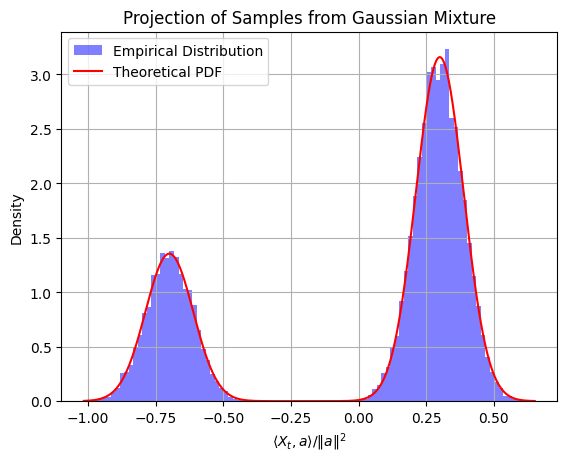

In [2]:
n = 128
p = 0.7
a = np.ones(n)
num_samples = 20000

mu1 = (1 - p) * a
mu2 = -p * a
cov = np.eye(n)

# Sample from the mixture model
components = np.random.choice([0, 1], size=num_samples, p=[p, 1 - p])
samples = np.array([
    multivariate_normal.rvs(mean=mu1 if c == 0 else mu2, cov=cov)
    for c in components
])

# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(samples, a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections, bins = 100, density=True, alpha=0.5, color='blue', label="Empirical Distribution")

# Plot the theoretical density (red line)
x = np.linspace(min(projections), max(projections), 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()

In [3]:
class TwoLayerDenoiser(nn.Module):
    def __init__(self, n, hidden_dim=256, L=3):
        super(TwoLayerDenoiser, self).__init__()
        self.lin0 = nn.Linear(42, L)                  # Time embedding φ → s
        self.lin1 = nn.Linear(n, hidden_dim)          # Input projection x → x1
        self.lin2 = nn.Linear(hidden_dim * L, n)      # Output projection

    def forward(self, x, alpha):
        batch_size = x.shape[0]
        alpha = alpha.unsqueeze(1)

        i_values = torch.arange(21, dtype=torch.float32, device=x.device)
        phi = torch.cat([torch.cos(alpha * i_values), torch.sin(alpha * i_values)], dim=1)

        s = self.lin0(phi)
        x1 = F.tanh(self.lin1(x))

        outer_product = torch.einsum("bi,bj->bij", s, x1)  # Shape: (B, L, hidden_dim)
        x2 = outer_product.view(batch_size, -1)

        x_out = self.lin2(x2) + torch.cos(alpha).pow(2) * x
        return x_out


In [4]:
denoiser = TwoLayerDenoiser(n)
training(denoiser, 
             samples,  
             num_epochs=500, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/500] | Train Loss: 0.5530 | Val Loss: 60.6139% | 


KeyboardInterrupt: 

In [5]:
#torch.save(denoiser.state_dict(), 'nn params/denoiser_tanh_weights.pth')
denoiser.load_state_dict(torch.load('nn params/denoiser_tanh_weights.pth'))
denoiser.eval()


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_30147/4099124115.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser.load_state_dict(torch.load('nn param

TwoLayerDenoiser(
  (lin0): Linear(in_features=42, out_features=3, bias=True)
  (lin1): Linear(in_features=128, out_features=256, bias=True)
  (lin2): Linear(in_features=768, out_features=128, bias=True)
)

In [6]:
K = 200
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = 5000
target_samples = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)

y_curr = []
alpha_curr = []

for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        if (it+1)%20 == 0:
              y_curr.append(target_samples)
              alpha_curr.append(alpha)
              print(alpha, t)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser(target_samples,alpha_vet )
        target_samples = target_samples + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples=target_samples/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_30147/2502730744.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples = target_samples + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor(24.3360)
tensor(0.1309) tensor(0.0173)
tensor(0.2686) tensor(0.0758)
tensor(0.4064) tensor(0.1852)
tensor(0.5442) tensor(0.3662)
tensor(0.6820) tensor(0.6592)
tensor(0.8197) tensor(1.1473)
tensor(0.9575) tensor(2.0185)
tensor(1.0953) tensor(3.7711)
tensor(1.2330) tensor(8.1063)


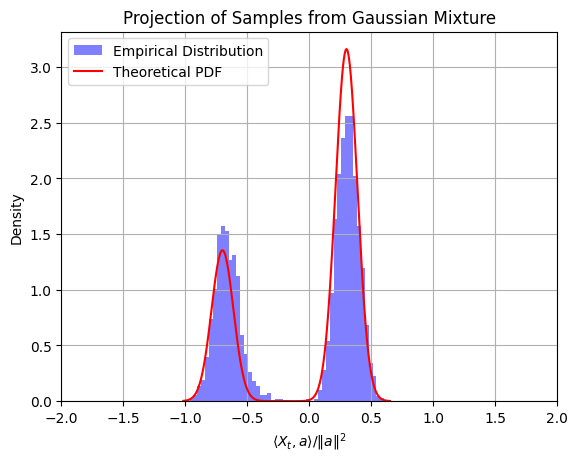

Projection mean: -0.07481521631300332
Projection std: 0.48503175455697156


In [7]:
# Compute the projection ⟨X_t, a⟩ / ||a||²
projections_final= np.dot(target_samples.detach().numpy(), a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections_final, bins = 50, density=True, alpha=0.5, color='blue', label="Empirical Distribution")
plt.xlim(-2, 2)  

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()

print("Projection mean:", projections_final.mean())
print("Projection std:", projections_final.std())

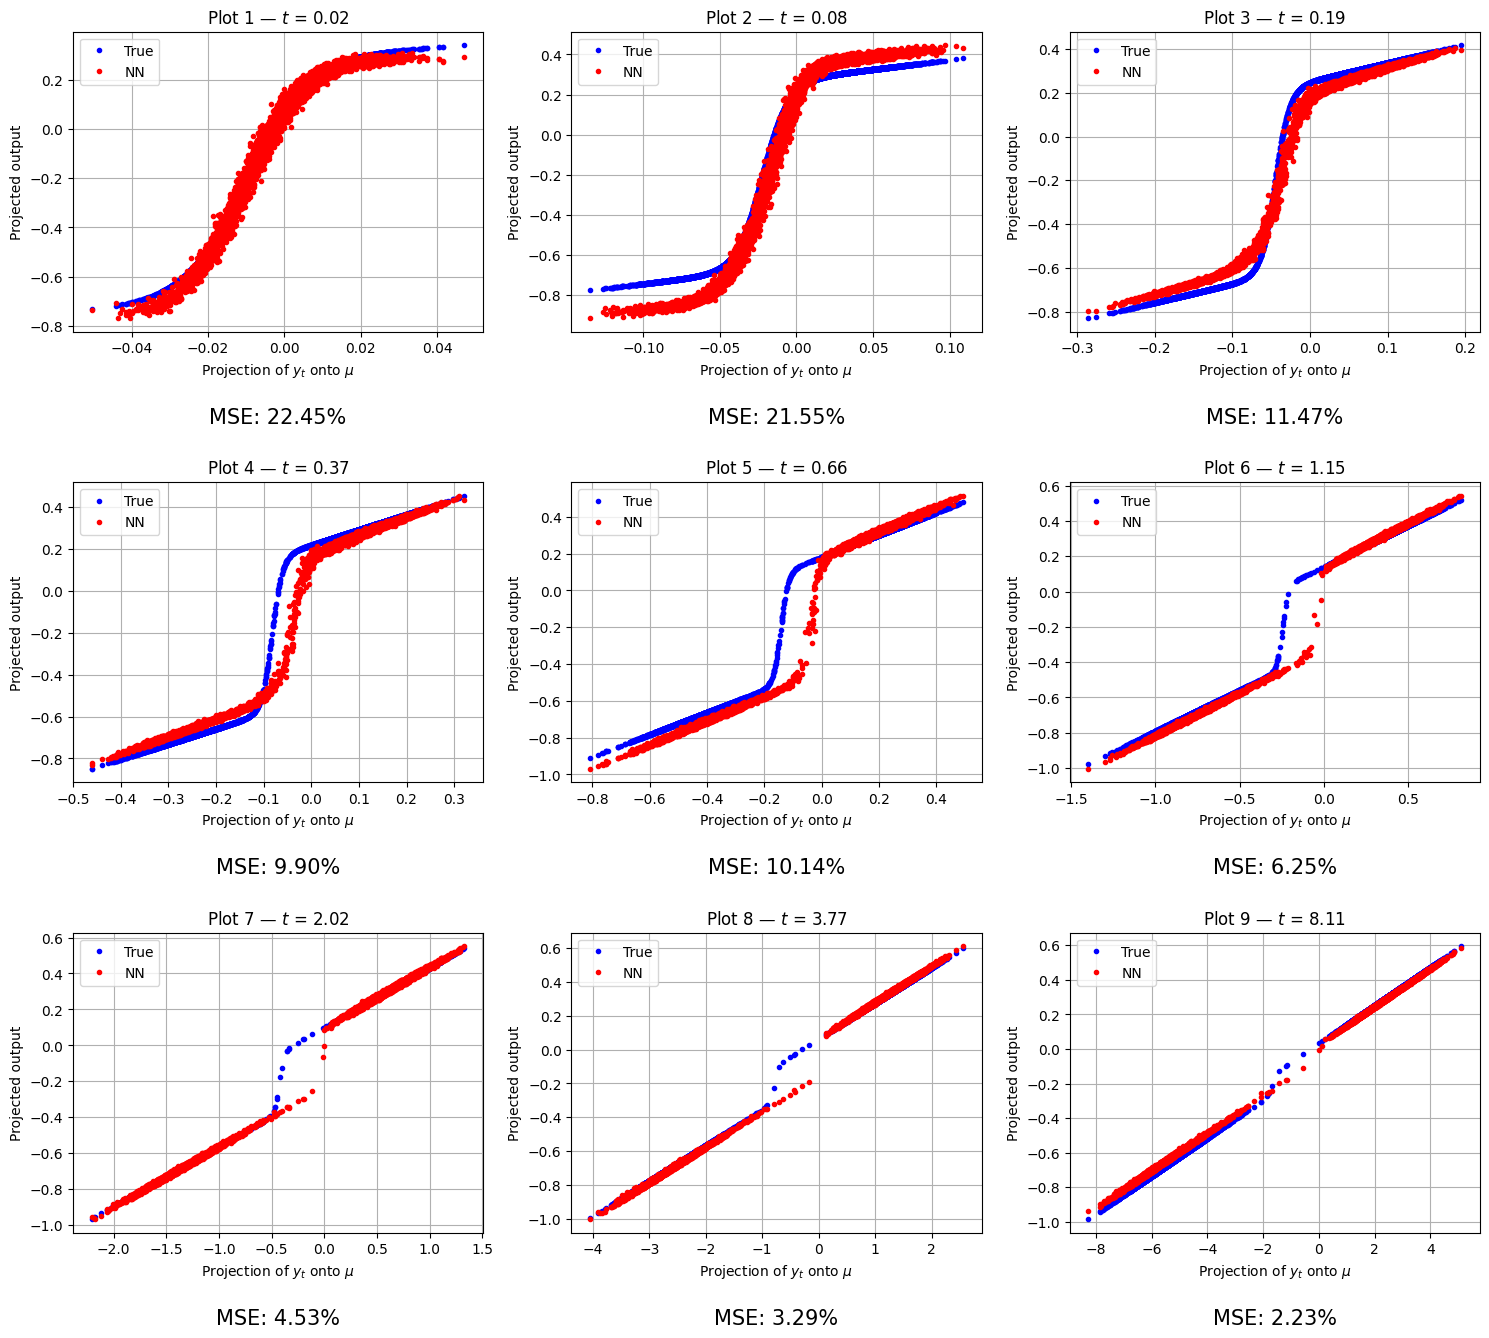

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

mu = a 
num_plots = len(alpha_curr)
cols = 3  # numero di colonne per riga
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
axes = axes.flatten()

a_norm_sq = np.linalg.norm(mu)**2

for i in range(num_plots):
    alpha = alpha_curr[i]
    t = torch.tan(alpha).pow(2).detach().numpy()
    alpha_vet = torch.full((num_samples_target,), alpha)

    y = y_curr[i].detach().numpy()
    true_output = compute_posterior_mean_multidim_batch(y, t, mu1, mu2, p)
    nn_output = denoiser(y_curr[i], alpha_vet).detach().numpy()

    true_proj = np.dot(true_output, mu) / a_norm_sq
    nn_proj = np.dot(nn_output, mu) / a_norm_sq
    projections_y = np.dot(y, mu) / a_norm_sq


    rel_mse = np.sqrt(
    np.sum((nn_output - true_output) ** 2, axis=1) /
    np.clip(np.sum(true_output ** 2, axis=1), a_min=1e-8, a_max=None))

    ax = axes[i]
    ax.plot(projections_y, true_proj, '.', color='blue', label='True')
    ax.plot(projections_y, nn_proj, '.', color='red', label='NN')
    ax.set_xlabel(r'Projection of $y_t$ onto $\mu$')
    ax.set_ylabel('Projected output')
    ax.set_title(f'Plot {i+1} — $t$ = {t:.2f}')
    ax.text(0.5, -0.25, f'MSE: {rel_mse.mean()*100:.2f}%', transform=ax.transAxes,
            fontsize=15, ha='center', va='top')  # Aumentato fontsize
    ax.grid(True)
    ax.legend()

# Nasconde eventuali subplot vuoti
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

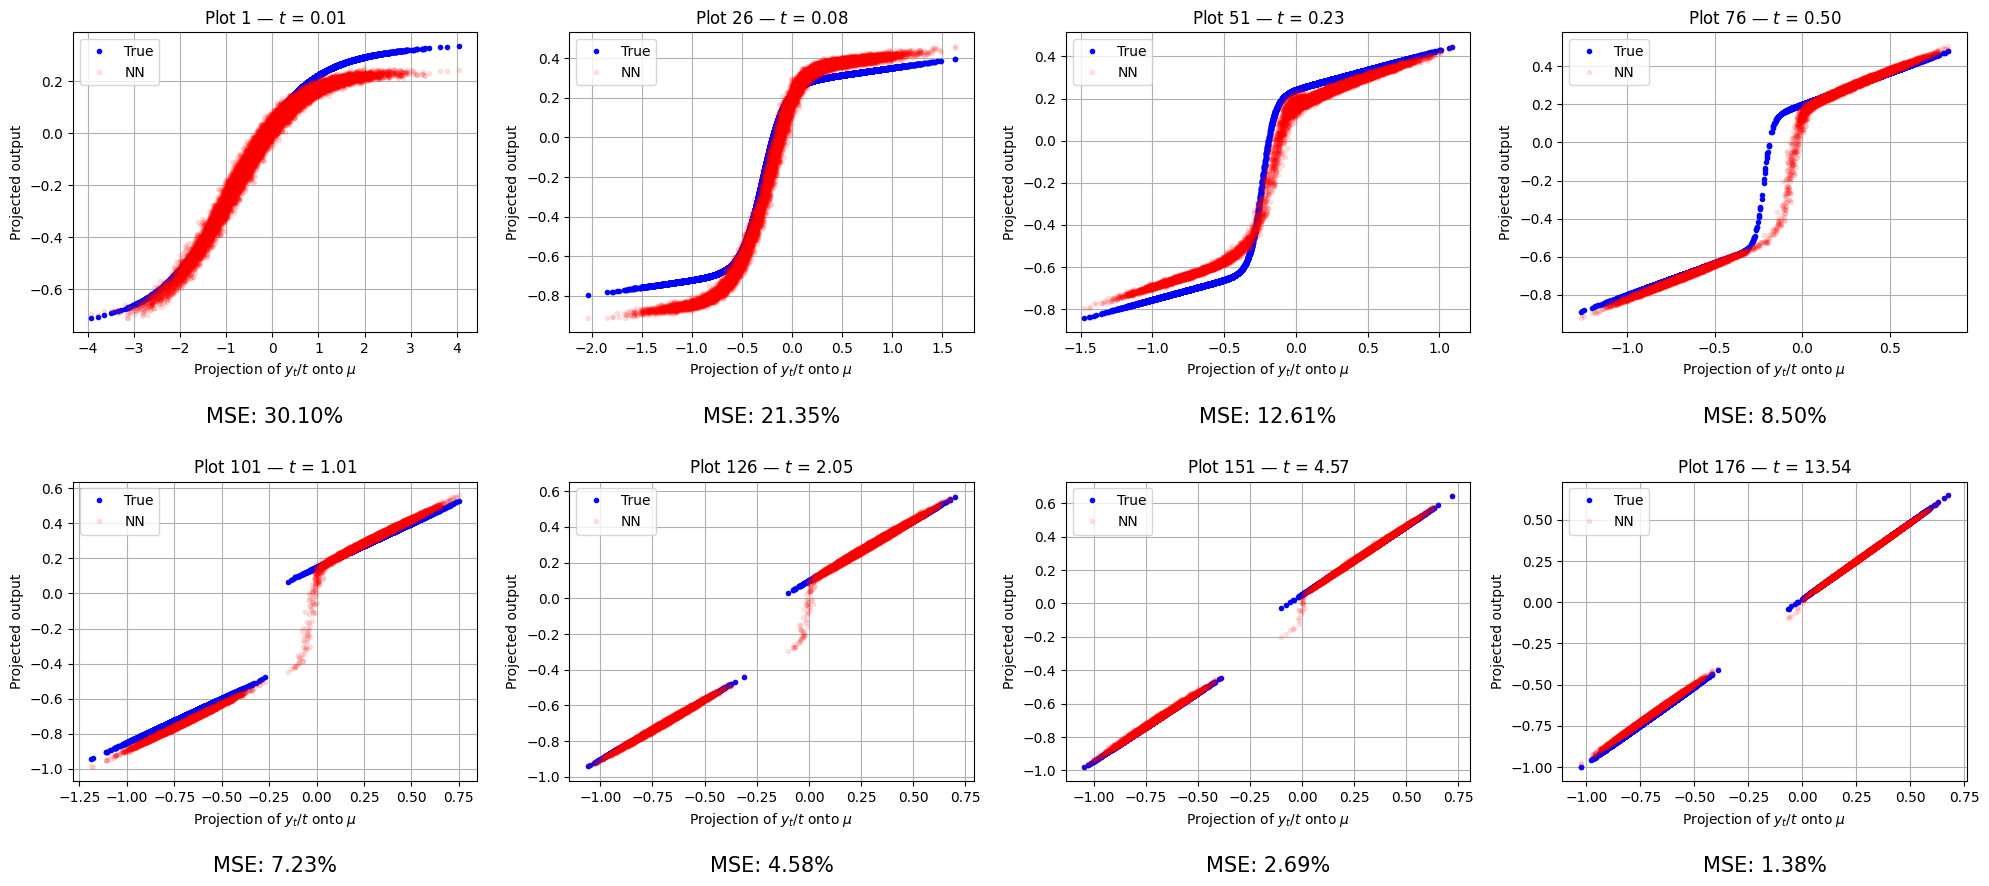

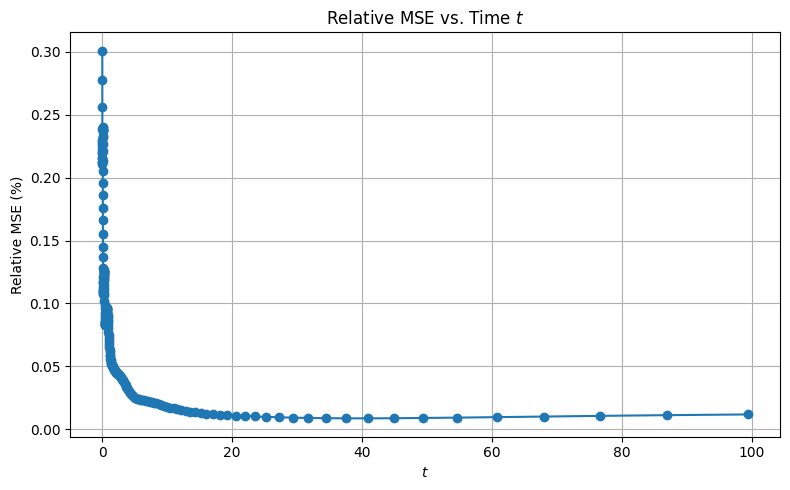

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

# Parameters
mu = a
a_norm_sq = np.linalg.norm(mu) ** 2
K = 200  # number of alpha values
num_samples = samples.shape[0]
alpha_grid = torch.linspace(0.1, np.pi / 2 - 0.1, K, dtype=torch.float32)

# Prepare grid for plots (1 every 20)
plot_every = 25
plot_indices = list(range(0, K, plot_every))
cols = 4
rows = math.ceil(len(plot_indices) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
axes = axes.flatten()

# Store errors
mse_list = []
t_list = []

# Prepare samples once
samples = torch.tensor(samples, dtype=torch.float32)

for i in range(K):
    alpha = alpha_grid[i]
    t = torch.tan(alpha).pow(2)
    t_np = t.detach().numpy()
    alpha_batch = torch.full((num_samples,), alpha)

    noise = torch.randn_like(samples)
    y_t = t * samples + t.sqrt() * noise
    y_np = y_t.detach().numpy()

    true_output = compute_posterior_mean_multidim_batch(y_np, t_np, mu1, mu2, p)
    nn_output = denoiser(y_t, alpha_batch).detach().numpy()

    rel_mse = np.sqrt(
        np.sum((nn_output - true_output) ** 2, axis=1) /
        np.clip(np.sum(true_output ** 2, axis=1), a_min=1e-8, a_max=None)
    )
    mse_list.append(rel_mse.mean().item())
    t_list.append(t_np)

    # Plot only every 20th
    if i in plot_indices:
        true_proj = np.dot(true_output, mu) / a_norm_sq
        nn_proj = np.dot(nn_output, mu) / a_norm_sq
        y_proj = (np.dot(y_np, mu) / a_norm_sq)/t

        ax = axes[plot_indices.index(i)]
        ax.plot(y_proj, true_proj, '.', color='blue', label='True')
        ax.plot(y_proj, nn_proj, '.', color='red', label='NN', alpha=0.1)
        ax.set_xlabel(r'Projection of $y_t/t$ onto $\mu$')
        ax.set_ylabel('Projected output')
        ax.set_title(f'Plot {i+1} — $t$ = {t:.2f}')
        ax.text(
            0.5, -0.25, f'MSE: {rel_mse.mean() * 100:.2f}%',
            transform=ax.transAxes, fontsize=15,
            ha='center', va='top'
        )
        ax.grid(True)
        ax.legend()

# Hide unused subplots
for j in range(len(plot_indices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# Plot MSE vs t
plt.figure(figsize=(8, 5))
plt.plot(t_list, mse_list, marker='o')
plt.xlabel(r'$t$')
plt.ylabel('Relative MSE (%)')
plt.title('Relative MSE vs. Time $t$')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
raise SystemExit("Execution stopped manually.")

SystemExit: Execution stopped manually.

/Users/edotarci/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## variant with two denoisers

In [ ]:
n = 128
p = 0.7
a = np.ones(n)
num_samples = 20000

mu1 = (1 - p) * a
mu2 = -p * a
cov = np.eye(n)

# Sample from the mixture model
components = np.random.choice([0, 1], size=num_samples, p=[p, 1 - p])
samples = np.array([
    multivariate_normal.rvs(mean=mu1 if c == 0 else mu2, cov=cov)
    for c in components
])

# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(samples, a) / a_norm_sq



# Plot the theoretical density (red line)
x = np.linspace(min(projections), max(projections), 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)



C = np.cov(samples, rowvar=False)
# Compute the principal eigenvector using Lanczos (ARPACK)
eigvals, eigvecs = eigsh(C, k=1, which='LM')
principal_eigenvector = eigvecs[:, 0]

# Fix sign ambiguity by enforcing a consistent sign
if principal_eigenvector[np.argmax(np.abs(principal_eigenvector))] < 0:
    principal_eigenvector *= -1  # Flip the sign

# Compute the condition number (ratio of largest to smallest eigenvalue)
eigvals_full = np.linalg.eigvalsh(C)
condition_number = eigvals_full[-1] / eigvals_full[0]
print(condition_number)

samples_plus = samples[samples@principal_eigenvector>=0]
samples_minus = samples[samples@principal_eigenvector<0]
q = len(samples_plus)/num_samples
print(len(samples_plus), q)

denoiser_plus = TwoLayerDenoiser(n)
denoiser_minus = TwoLayerDenoiser(n)

32.412332186646246
14094 0.7047


# Training of denoiser_plus

In [ ]:
denoiser_plus = TwoLayerDenoiser(n)
training(denoiser_plus, 
             samples_plus,  
             num_epochs=2000, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/2000] | Train Loss: 0.5084 | Val Loss: 61.6894% | 
Epoch [51/2000] | Train Loss: 0.4955 | Val Loss: 61.6262% | 
Epoch [101/2000] | Train Loss: 0.5054 | Val Loss: 61.6128% | 
Epoch [151/2000] | Train Loss: 0.5008 | Val Loss: 61.9915% | 
Epoch [201/2000] | Train Loss: 0.4983 | Val Loss: 61.9912% | 
Epoch [251/2000] | Train Loss: 0.4999 | Val Loss: 61.5968% | 
Epoch [301/2000] | Train Loss: 0.5100 | Val Loss: 61.6959% | 
Epoch [351/2000] | Train Loss: 0.5026 | Val Loss: 61.7949% | 
Epoch [401/2000] | Train Loss: 0.4965 | Val Loss: 61.6336% | 
Epoch [451/2000] | Train Loss: 0.5047 | Val Loss: 61.8277% | 
Epoch [501/2000] | Train Loss: 0.5002 | Val Loss: 61.9031% | 
Epoch [551/2000] | Train Loss: 0.4990 | Val Loss: 60.8674% | 
Epoch [601/2000] | Train Loss: 0.5059 | Val Loss: 61.4933% | 
Epoch [651/2000] | Train Loss: 0.4975 | Val Loss: 61.4544% | 
Epoch [701/2000] | Train Loss: 0.5051 | Val Loss: 61.7308% | 
Epoch [751/2000] | Train Loss: 0.5055 | Val Loss: 61.8775% | 
Epoch [801/

0

In [ ]:
torch.save(denoiser_plus.state_dict(), 'nn params/denoiser_tanh_plus_weights.pth')
denoiser_plus.load_state_dict(torch.load('nn params/denoiser_tanh_plus_weights.pth'))
denoiser_plus.eval()

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_94152/150505556.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser_plus.load_state_dict(torch.load('nn p

TwoLayerDenoiser(
  (lin0): Linear(in_features=42, out_features=3, bias=True)
  (lin1): Linear(in_features=128, out_features=256, bias=True)
  (lin2): Linear(in_features=768, out_features=128, bias=True)
)

# Training of denoiser_minus

In [ ]:
denoiser_minus = TwoLayerDenoiser(n)
training(denoiser_minus, 
             samples_minus,  
             num_epochs=2000, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/2000] | Train Loss: 0.6131 | Val Loss: 53.4267% | 
Epoch [51/2000] | Train Loss: 0.5039 | Val Loss: 52.4465% | 
Epoch [101/2000] | Train Loss: 0.4954 | Val Loss: 52.8747% | 
Epoch [151/2000] | Train Loss: 0.5091 | Val Loss: 52.8608% | 
Epoch [201/2000] | Train Loss: 0.5162 | Val Loss: 52.8448% | 
Epoch [251/2000] | Train Loss: 0.5036 | Val Loss: 52.2227% | 
Epoch [301/2000] | Train Loss: 0.5123 | Val Loss: 52.5377% | 
Epoch [351/2000] | Train Loss: 0.4979 | Val Loss: 53.5466% | 
Epoch [401/2000] | Train Loss: 0.4993 | Val Loss: 53.6446% | 
Epoch [451/2000] | Train Loss: 0.5015 | Val Loss: 53.2417% | 
Epoch [501/2000] | Train Loss: 0.5074 | Val Loss: 53.0091% | 
Epoch [551/2000] | Train Loss: 0.5031 | Val Loss: 52.2257% | 
Epoch [601/2000] | Train Loss: 0.4944 | Val Loss: 52.9947% | 
Epoch [651/2000] | Train Loss: 0.4959 | Val Loss: 52.8519% | 
Epoch [701/2000] | Train Loss: 0.5005 | Val Loss: 53.2282% | 
Epoch [751/2000] | Train Loss: 0.5004 | Val Loss: 52.3443% | 
Epoch [801/

0

In [ ]:
torch.save(denoiser_minus.state_dict(), 'nn params/denoiser_tanh_minus_weights.pth')
denoiser_minus.load_state_dict(torch.load('nn params/denoiser_tanh_minus_weights.pth'))
denoiser_minus.eval()

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_94152/3589185535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser_minus.load_state_dict(torch.load('nn

TwoLayerDenoiser(
  (lin0): Linear(in_features=42, out_features=3, bias=True)
  (lin1): Linear(in_features=128, out_features=256, bias=True)
  (lin2): Linear(in_features=768, out_features=128, bias=True)
)

# Diffusion with denoiser_plus

In [ ]:
K = 400
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = int(np.floor(5000*q))
target_samples_plus = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)


for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser_plus(target_samples_plus, alpha_vet )
        target_samples_plus = target_samples_plus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples_plus=target_samples_plus/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))
print(target_samples_plus)

tensor(24.3360)


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_94152/4047415394.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples_plus = target_samples_plus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor([[-0.2612,  1.5933,  1.2221,  ...,  0.9198,  1.8329,  0.4780],
        [ 0.8538, -0.4331,  1.1205,  ...,  1.1610,  1.4668, -0.8562],
        [ 1.1066,  0.5976,  0.6060,  ...,  1.3384,  0.4414,  0.4645],
        ...,
        [-0.0947,  0.8950,  1.5002,  ..., -0.0158,  0.5202, -1.2071],
        [ 1.3626, -0.0750,  1.0987,  ...,  1.7499,  0.9127,  0.5886],
        [ 0.7325,  1.4680,  1.3212,  ..., -0.9685, -0.3027, -0.7688]],
       grad_fn=<DivBackward0>)


# Diffusion with denoiser_minus

In [ ]:
K = 400
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = int(np.floor(5000*(1-q)))
target_samples_minus = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)


for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser_minus(target_samples_minus,alpha_vet )
        target_samples_minus = target_samples_minus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples_minus=target_samples_minus/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))
print(target_samples_minus)

tensor(24.3360)


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_94152/438514904.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples_minus = target_samples_minus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor([[-2.9103, -1.1123,  0.2190,  ..., -0.0512, -0.9674,  0.3527],
        [-0.1975, -0.0762, -0.2259,  ..., -1.6634, -1.8982, -1.2253],
        [ 0.5678, -0.7258, -1.5700,  ...,  1.0284,  0.4320, -1.0338],
        ...,
        [-0.9663, -1.8407, -0.1646,  ..., -2.8039, -1.4817, -1.1014],
        [-0.1121, -0.3545, -0.3013,  ...,  1.2359, -1.3970, -2.2411],
        [-0.8970, -1.4408,  0.4371,  ..., -1.4899, -2.4327,  0.0373]],
       grad_fn=<DivBackward0>)


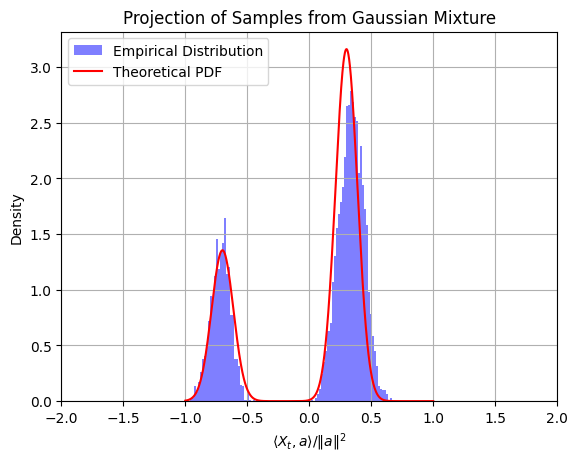

In [ ]:
target_samples = torch.cat((target_samples_minus,target_samples_plus))
# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(target_samples.detach().numpy(), a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections, bins = 100, density=True, alpha=0.5, color='blue', label="Empirical Distribution")
plt.xlim(-2, 2)  

# Plot the theoretical density (red line)
x = np.linspace(-1, 1, 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()